In [3]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm

# processing
from sklearn.model_selection import train_test_split

# parameters search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# scoring
import math
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap
import datetime

# save model
import pickle
import os
import joblib

# Import constants
import config


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
# Load Data

Psy = pd.read_csv(f"{config.BASE_PATH}/Psychology.csv")
Psy

,Date_Time,bldgname,KW,KW/SQM,CHWTON,CHWTON/SQM,HTmmBTU,HTmmBTU/SQM,AirT_North,AirT_East,...,Shade_North,Shade_East,Shade_South,Shade_West,Shade_Top,Area_North,Area_East,Area_South,Area_West,Area_Top
0,2023-05-03 05:00:00,Psychology,115.33,0.017769,76.52,0.011789,0.25,0.000039,21.967301,22.163870,...,1.0,1.0,1.000000,1.000000,1.0000,1064.0,784.0,1064.0,784.0,2500.0
1,2023-05-03 05:15:00,Psychology,116.74,0.017986,72.20,0.011124,0.26,0.000040,22.031662,22.443350,...,1.0,1.0,1.000000,1.000000,1.0000,1064.0,784.0,1064.0,784.0,2500.0
2,2023-05-03 05:30:00,Psychology,118.65,0.018280,71.63,0.011036,0.26,0.000040,21.670921,22.125737,...,1.0,1.0,1.000000,1.000000,1.0000,1064.0,784.0,1064.0,784.0,2500.0
3,2023-05-03 05:45:00,Psychology,114.99,0.017716,75.15,0.011578,0.24,0.000037,21.493868,21.963489,...,1.0,1.0,1.000000,1.000000,1.0000,1064.0,784.0,1064.0,784.0,2500.0
4,2023-05-03 06:00:00,Psychology,130.32,0.020078,73.51,0.011326,0.24,0.000037,21.292527,21.783249,...,1.0,1.0,1.000000,1.000000,1.0000,1064.0,784.0,1064.0,784.0,2500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,2023-07-18 13:30:00,Psychology,162.98,0.025110,236.26,0.036400,0.13,0.000020,44.091477,43.852029,...,1.0,1.0,0.098086,0.279221,0.0080,1064.0,784.0,1064.0,784.0,2500.0
1577,2023-07-18 13:45:00,Psychology,154.92,0.023868,211.66,0.032610,0.13,0.000020,44.282061,44.004436,...,1.0,1.0,0.093301,0.344156,0.0144,1064.0,784.0,1064.0,784.0,2500.0
1578,2023-07-18 14:00:00,Psychology,152.20,0.023449,218.53,0.033669,0.12,0.000018,44.474969,44.192838,...,1.0,1.0,0.098086,0.370130,0.0224,1064.0,784.0,1064.0,784.0,2500.0
1579,2023-07-18 14:15:00,Psychology,151.80,0.023388,222.14,0.034225,0.07,0.000011,44.634005,44.329312,...,1.0,1.0,0.098086,0.334416,0.0224,1064.0,784.0,1064.0,784.0,2500.0


# Psychology

In [6]:
# Train/Test Data

df = Psy.copy()
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
#df = df[(df['Date_Time'].dt.hour >= 8) & (df['Date_Time'].dt.hour <= 20)]

# Filter out the data for July 7
test_data = df[(df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7)]
train_data = df[~((df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7))]

model_cols = ['CHWTON/SQM','AirT_Mean', 'AbsH_Mean','ShortW_North',
              'ShortW_East', 'ShortW_South', 'ShortW_West', 'ShortW_Top',
             'Shade_North', 'Shade_East', 'Shade_South', 'Shade_West', 'Shade_Top', 'KW/SQM']

train_data = train_data[model_cols]
test_data = test_data[model_cols]

# Prepare features and target variable
X_train = train_data.drop('CHWTON/SQM', axis=1)
y_train = train_data['CHWTON/SQM']
X_test = test_data.drop('CHWTON/SQM', axis=1)
y_test = test_data['CHWTON/SQM']

# Output the shapes of the datasets and missing values information
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1506, 13), (75, 13), (1506,), (75,))

,AirT_Mean,AbsH_Mean,ShortW_North,ShortW_East,ShortW_South,ShortW_West,ShortW_Top,Shade_North,Shade_East,Shade_South,Shade_West,Shade_Top,KW/SQM
0,22.217801,5.028799,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.000000,1.000000,1.0000,0.017769
1,22.220676,5.700938,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.000000,1.000000,1.0000,0.017986
2,21.892106,5.522933,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.000000,1.000000,1.0000,0.018280
3,21.733381,5.490080,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.000000,1.000000,1.0000,0.017716
4,21.549713,5.444180,0.0,0.0,0.000000,0.000000,0.000000,1.0,1.0,1.000000,1.000000,1.0000,0.020078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1576,43.867376,9.304210,0.0,0.0,72.095923,80.463530,1054.249724,1.0,1.0,0.098086,0.279221,0.0080,0.025110
1577,44.059024,9.281645,0.0,0.0,68.913908,100.354759,1033.664338,1.0,1.0,0.093301,0.344156,0.0144,0.023868
1578,44.256798,9.248373,0.0,0.0,59.100402,145.444498,983.170678,1.0,1.0,0.098086,0.370130,0.0224,0.023449
1579,44.415822,9.196790,0.0,0.0,54.632761,172.665707,952.210446,1.0,1.0,0.098086,0.334416,0.0224,0.023388


In [82]:
# Train Model 

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],   # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]         # Method of selecting samples for training each tree
}


rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_



Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100;

In [83]:
print("Best parameters found: ", best_params)

# Predict on the testing data
y_pred = best_rf_model.predict(X_test)

# Calculate the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Best parameters found:  {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 1.0656687967149457e-06
R-squared: 0.9361527024226451


High_Albedo_Walls
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.9288053437217003
Percent Difference:  -0.117561270142326


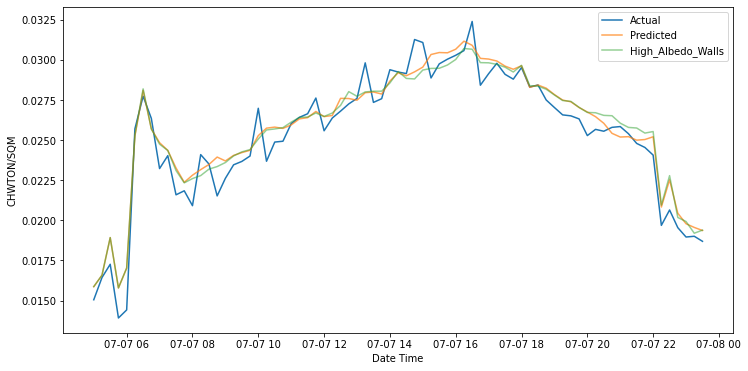

Cool_Pavement
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.9284791296043486
Percent Difference:  -0.1344541420411165


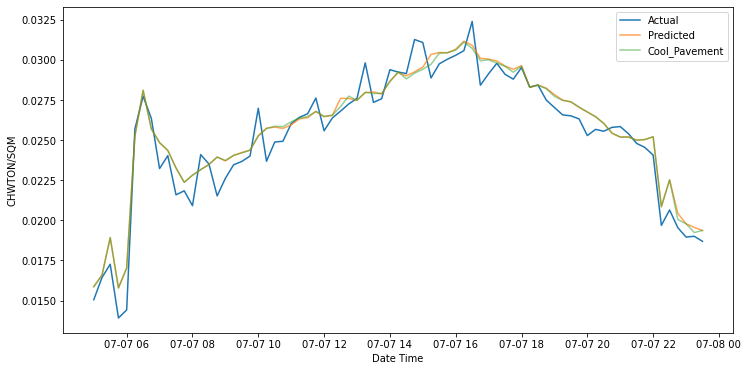

Trees_Surround
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.8791729421761296
Percent Difference:  -2.6877559880943527


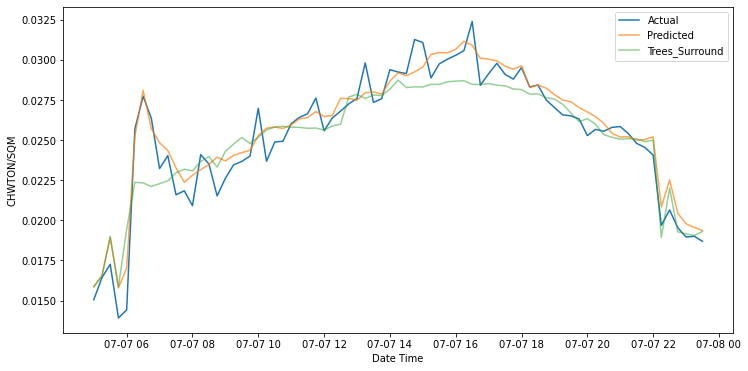

Wall_Shade
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.9179814019186152
Percent Difference:  -0.6780749100911501


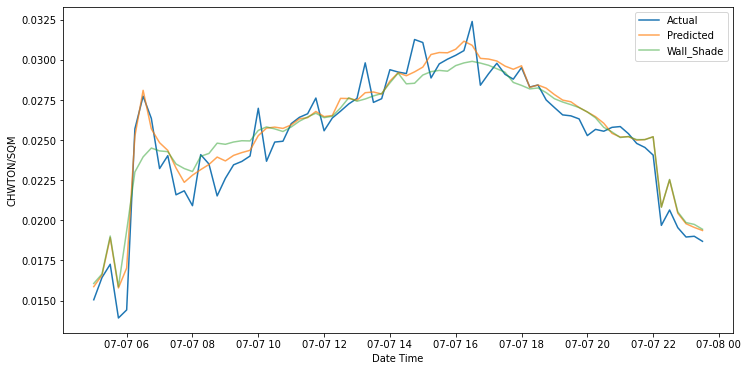

PV_Sidewalks
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.9183100297326208
Percent Difference:  -0.6610570458446721


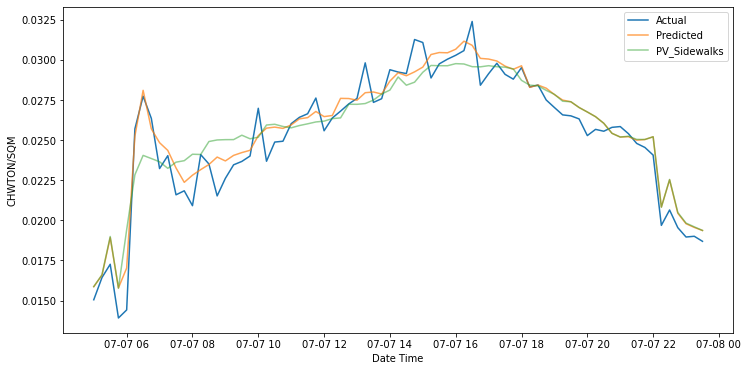

PV_Rooftop_and_Trees
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.8740972556197601
Percent Difference:  -2.950598453317057


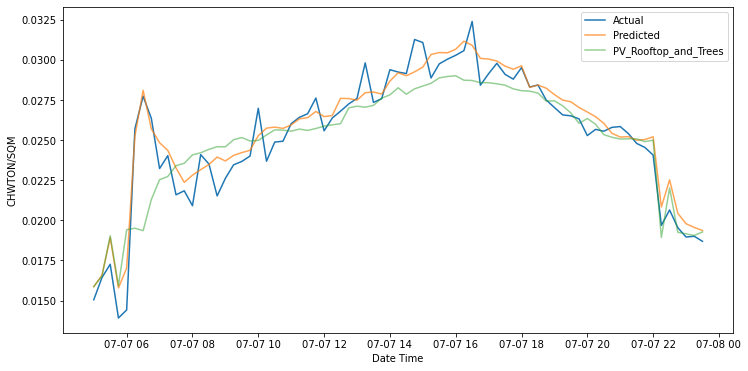

Trees_Extreme
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.8608740982939251
Percent Difference:  -3.635354541178431


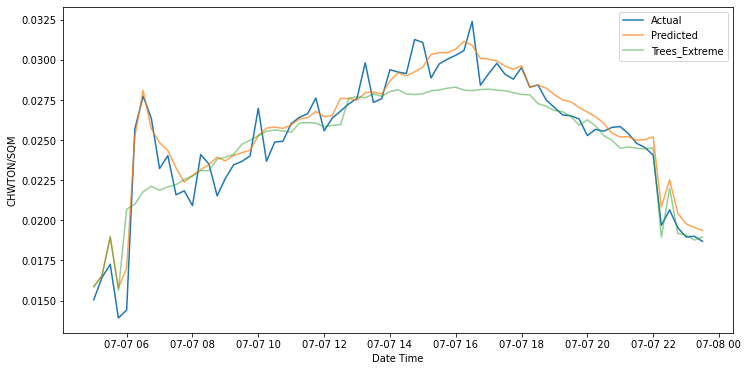

PV_Rooftop
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.9174314700542443
Percent Difference:  -0.7065529189930941


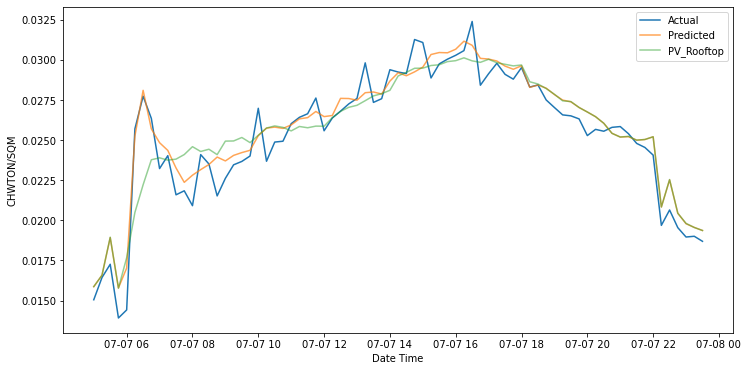

PV_Sidewalks_2
Prediceted Total (CHWTON/SWM):  1.9310755406547018
Scenario Total (CHWTON/SWM):   1.9189211704307203
Percent Difference:  -0.6294093611615378


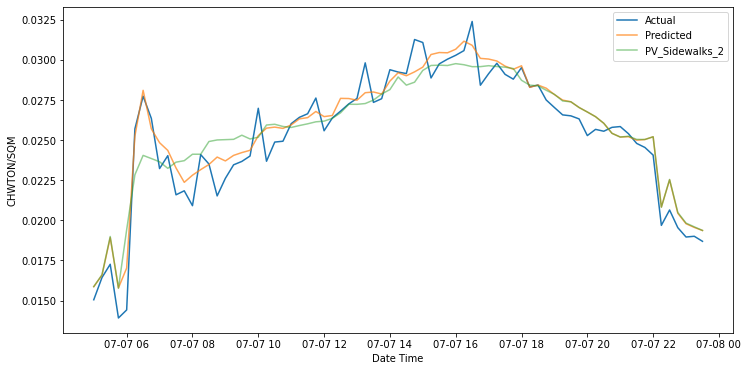

In [85]:
folder_path = '/Users/alialyakoob/Dropbox/ENVI-met/Model_2/Scenario_Dataset/'
scens = os.listdir(folder_path)
scens = list(filter(lambda x: x != '.DS_Store', scens))  


for i in scens:

    scen_data = pd.read_csv('/Users/alialyakoob/Dropbox/ENVI-met/Model_2/Scenario_Dataset/' + 
                            i + '/Psychology.csv')
    scen_data['Date_Time'] = pd.to_datetime(scen_data['Date_Time'])
    scen_data = scen_data[(scen_data['Date_Time'].dt.month == 7) & (scen_data['Date_Time'].dt.day == 7)]
    #scen_data = scen_data[(scen_data['Date_Time'].dt.hour >= 8) & (scen_data['Date_Time'].dt.hour <= 20)]
    scen_data = scen_data.drop_duplicates(subset=['Date_Time'])


    X_scen = scen_data[X_test.columns]
    scen_pred = best_rf_model.predict(X_scen)

    # Extract Date_Time for the test set
    date_time_test = df[(df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7)]['Date_Time']

    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        'Date_Time': date_time_test,
        'Actual': y_test,
        'Predicted': y_pred,
        'Scenario' : scen_pred
    })

    # Calculations
    sum_p = sum(plot_df['Predicted'])
    sum_s = sum(plot_df['Scenario'])
    print("\033[1m" + i + "\033[0m")
    print('Prediceted Total (CHWTON/SWM): ', sum_p)
    print('Scenario Total (CHWTON/SWM):  ', sum_s)
    print('Percent Difference: ', ((sum_s - sum_p)/sum_p)*100)
    
    # Sort by Date_Time
    plot_df.sort_values(by='Date_Time', inplace=True)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['Date_Time'], plot_df['Actual'], label='Actual')
    plt.plot(plot_df['Date_Time'], plot_df['Predicted'], label='Predicted', alpha=0.7)
    plt.plot(plot_df['Date_Time'], plot_df['Scenario'], label= i, alpha = 0.5)
    plt.xlabel('Date Time')
    plt.ylabel('CHWTON/SQM')
    plt.legend()
    plt.show()



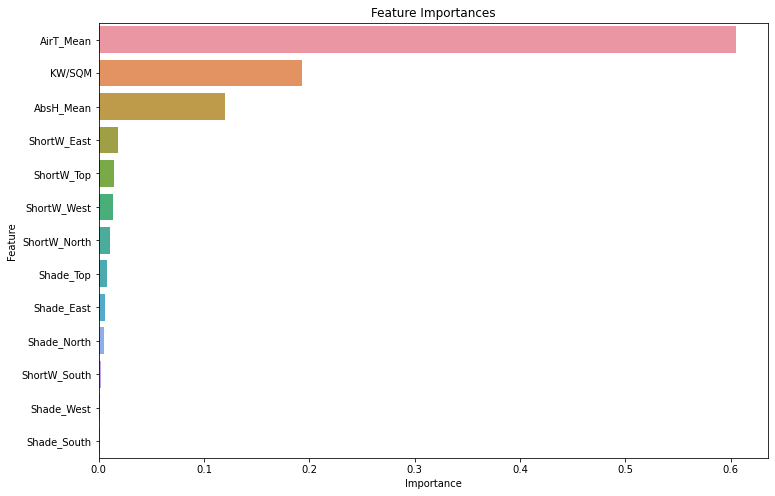

In [86]:
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
# Combine importances and feature names into a DataFrame and sort
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


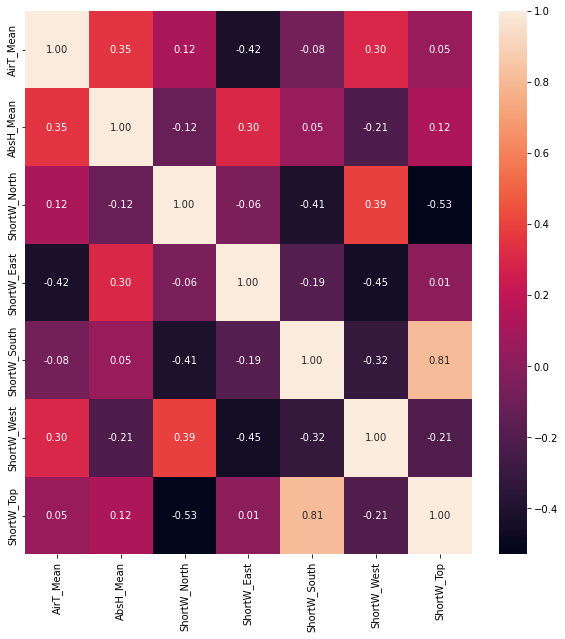

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()


# Psychology North

In [76]:
# Train/Test Data

df = PsyN.copy()
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
#df = df[(df['Date_Time'].dt.hour >= 8) & (df['Date_Time'].dt.hour <= 20)]

# Filter out the data for July 7
test_data = df[(df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7)]
train_data = df[~((df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7))]

model_cols = ['CHWTON/SQM','AirT_Mean', 'AbsH_Mean','ShortW_North',
              'ShortW_East', 'ShortW_South', 'ShortW_West', 'ShortW_Top',
             'Shade_North', 'Shade_East', 'Shade_South', 'Shade_West', 'Shade_Top', 'KW/SQM']

train_data = train_data[model_cols]
test_data = test_data[model_cols]

# Prepare features and target variable
X_train = train_data.drop('CHWTON/SQM', axis=1)
y_train = train_data['CHWTON/SQM']
X_test = test_data.drop('CHWTON/SQM', axis=1)
y_test = test_data['CHWTON/SQM']

# Output the shapes of the datasets and missing values information
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1506, 13), (75, 13), (1506,), (75,))

In [77]:
# Train Model 

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],   # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]         # Method of selecting samples for training each tree
}


rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_



Fitting 3 folds for each of 432 candidates, totalling 1296 fits


In [78]:
print("Best parameters found: ", best_params)

# Predict on the testing data
y_pred = best_rf_model.predict(X_test)

# Calculate the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 1.9309549995569955e-06
R-squared: 0.9221898945381567


High_Albedo_Walls
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.5881506510808245
Percent Difference:  0.060155424736574946


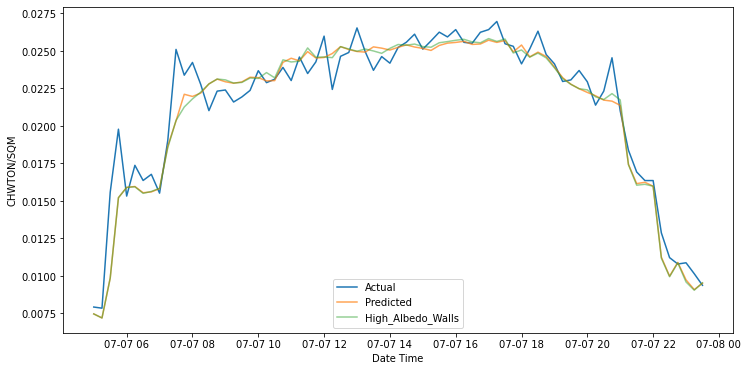

Cool_Pavement
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.5885558802091224
Percent Difference:  0.08568656029510753


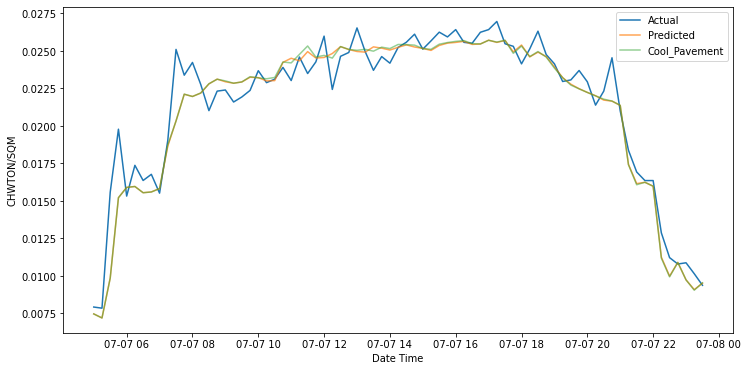

Trees_Surround
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.5377628974654394
Percent Difference:  -3.114484496751694


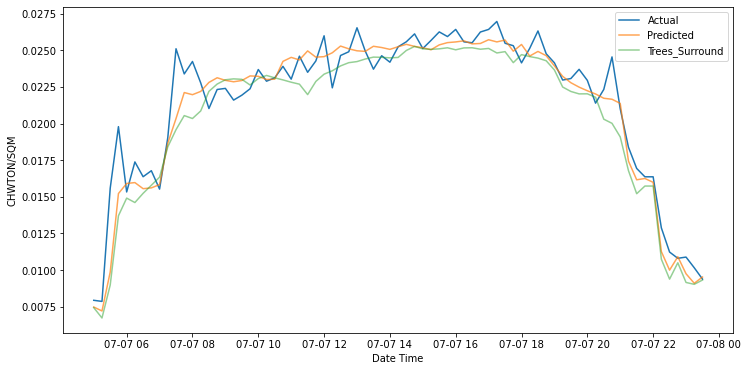

Wall_Shade
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.5824758968221395
Percent Difference:  -0.2973779067107775


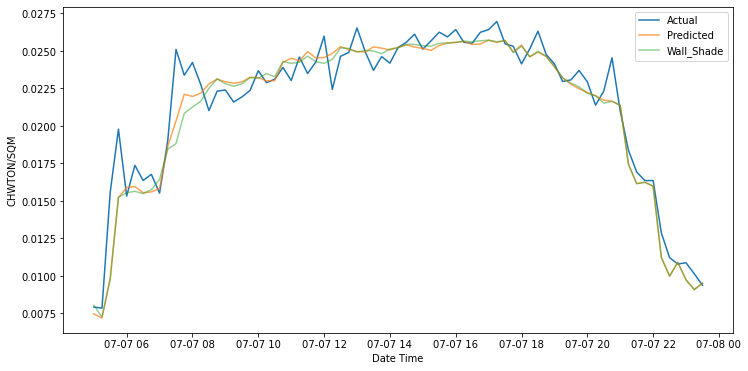

PV_Sidewalks
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.567633007858275
Percent Difference:  -1.2325421971171346


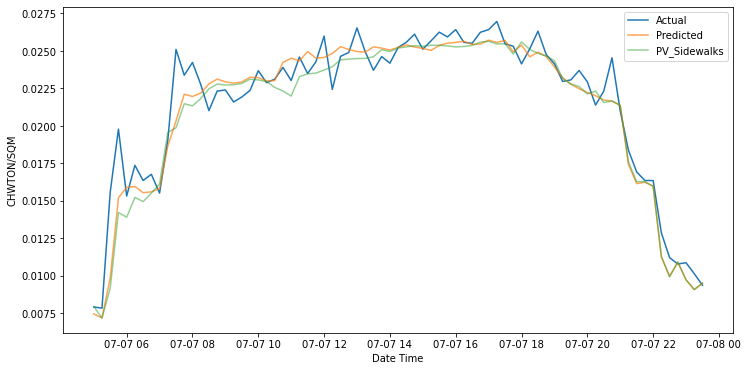

PV_Rooftop_and_Trees
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.5219427344293537
Percent Difference:  -4.111221154673982


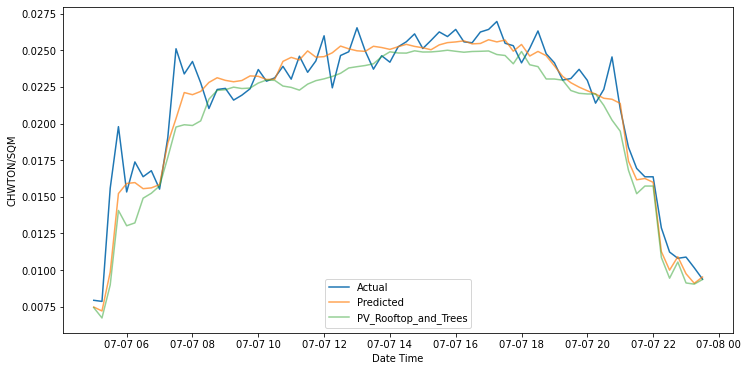

Trees_Extreme
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.504498885897786
Percent Difference:  -5.210256812334273


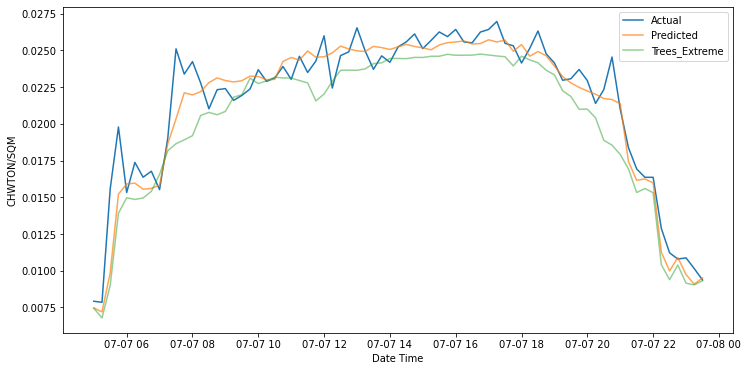

PV_Rooftop
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.5548506218698033
Percent Difference:  -2.0378861535201485


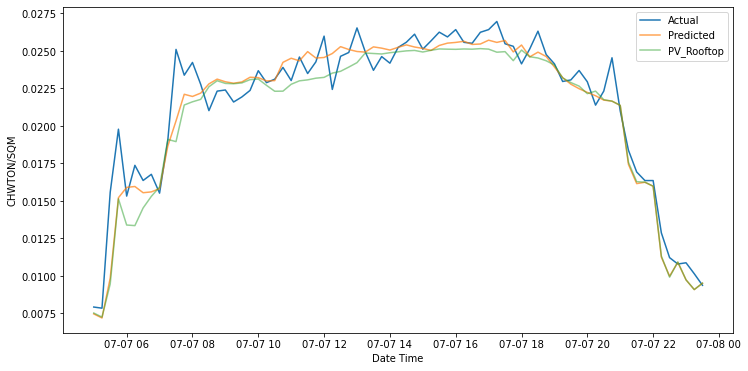

PV_Sidewalks_2
Prediceted Total (CHWTON/SWM):  1.5871958666658303
Scenario Total (CHWTON/SWM):   1.5682907117085005
Percent Difference:  -1.1911040946095228


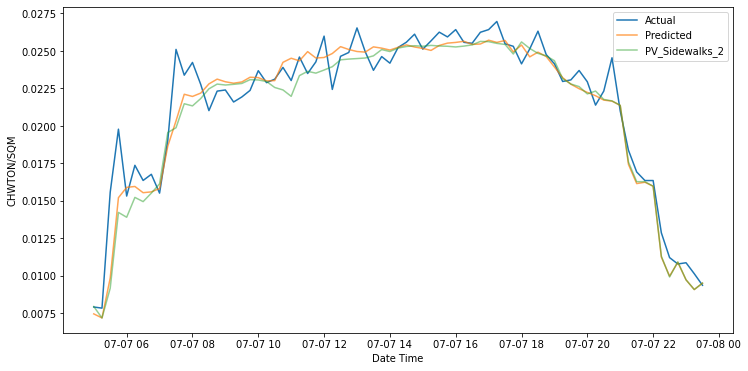

In [79]:
folder_path = '/Users/alialyakoob/Dropbox/ENVI-met/Model_2/Scenario_Dataset/'
scens = os.listdir(folder_path)
scens = list(filter(lambda x: x != '.DS_Store', scens))  


for i in scens:

    scen_data = pd.read_csv('/Users/alialyakoob/Dropbox/ENVI-met/Model_2/Scenario_Dataset/' + 
                            i + '/Psychology_North.csv')
    scen_data['Date_Time'] = pd.to_datetime(scen_data['Date_Time'])
    scen_data = scen_data[(scen_data['Date_Time'].dt.month == 7) & (scen_data['Date_Time'].dt.day == 7)]
    #scen_data = scen_data[(scen_data['Date_Time'].dt.hour >= 8) & (scen_data['Date_Time'].dt.hour <= 20)]
    scen_data = scen_data.drop_duplicates(subset=['Date_Time'])


    X_scen = scen_data[X_test.columns]
    scen_pred = best_rf_model.predict(X_scen)

    # Extract Date_Time for the test set
    date_time_test = df[(df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7)]['Date_Time']

    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        'Date_Time': date_time_test,
        'Actual': y_test,
        'Predicted': y_pred,
        'Scenario' : scen_pred
    })

    # Calculations
    sum_p = sum(plot_df['Predicted'])
    sum_s = sum(plot_df['Scenario'])
    print("\033[1m" + i + "\033[0m")
    print('Prediceted Total (CHWTON/SWM): ', sum_p)
    print('Scenario Total (CHWTON/SWM):  ', sum_s)
    print('Percent Difference: ', ((sum_s - sum_p)/sum_p)*100)
    
    # Sort by Date_Time
    plot_df.sort_values(by='Date_Time', inplace=True)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['Date_Time'], plot_df['Actual'], label='Actual')
    plt.plot(plot_df['Date_Time'], plot_df['Predicted'], label='Predicted', alpha=0.7)
    plt.plot(plot_df['Date_Time'], plot_df['Scenario'], label= i, alpha = 0.5)
    plt.xlabel('Date Time')
    plt.ylabel('CHWTON/SQM')
    plt.legend()
    plt.show()



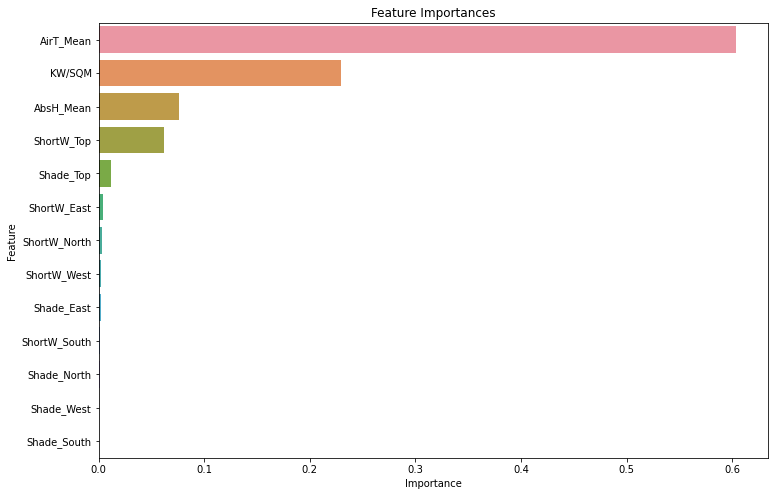

In [80]:
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
# Combine importances and feature names into a DataFrame and sort
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


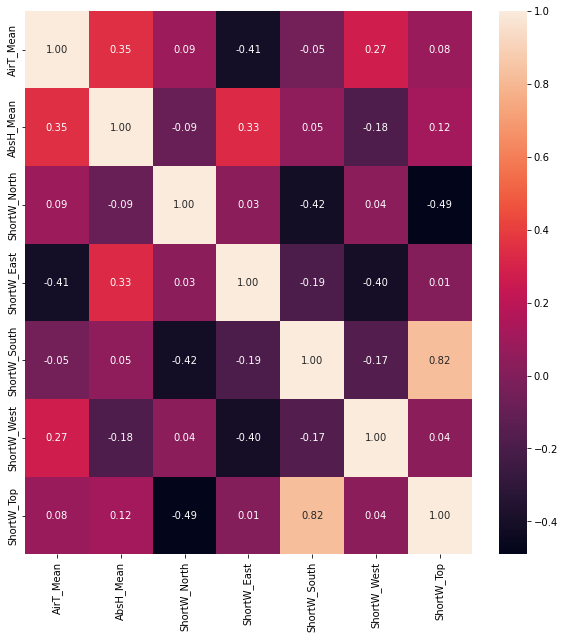

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()


# ISTB 4

In [87]:
# Train/Test Data

df = Istb.copy()
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
#df = df[(df['Date_Time'].dt.hour >= 8) & (df['Date_Time'].dt.hour <= 20)]

# Filter out the data for July 7
test_data = df[(df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7)]
train_data = df[~((df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7))]

model_cols = ['CHWTON/SQM','AirT_Mean', 'AbsH_Mean','ShortW_North',
              'ShortW_East', 'ShortW_South', 'ShortW_West', 'ShortW_Top',
             'Shade_North', 'Shade_East', 'Shade_South', 'Shade_West', 'Shade_Top', 'KW/SQM']

train_data = train_data[model_cols]
test_data = test_data[model_cols]

# Prepare features and target variable
X_train = train_data.drop('CHWTON/SQM', axis=1)
y_train = train_data['CHWTON/SQM']
X_test = test_data.drop('CHWTON/SQM', axis=1)
y_test = test_data['CHWTON/SQM']

# Output the shapes of the datasets and missing values information
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1511, 13), (75, 13), (1511,), (75,))

In [88]:
# Train Model 

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],   # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required at each leaf node
    'bootstrap': [True, False]         # Method of selecting samples for training each tree
}


rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_



Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; t

In [89]:
print("Best parameters found: ", best_params)

# Predict on the testing data
y_pred = best_rf_model.predict(X_test)

# Calculate the metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Mean Squared Error: 1.6127191484187096e-06
R-squared: 0.7005745284161558


High_Albedo_Walls
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.252775381252406
Percent Difference:  -2.387837841883035


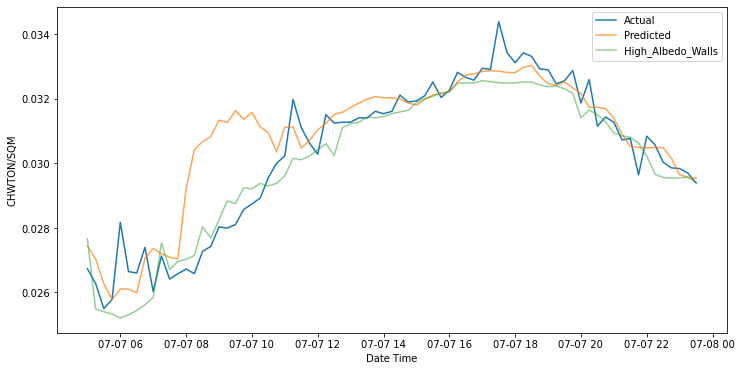

Cool_Pavement
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.2538985412414987
Percent Difference:  -2.339171616258761


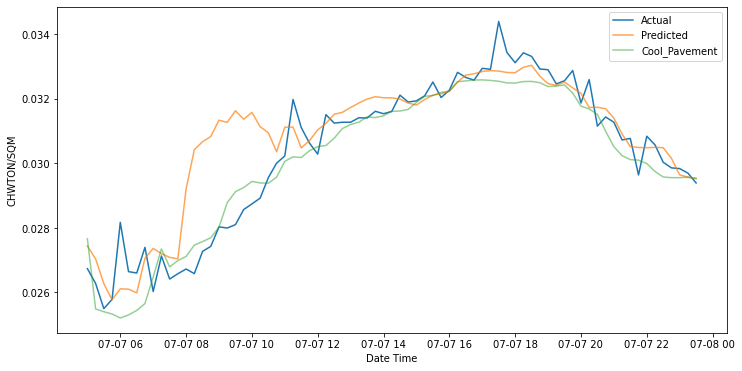

Trees_Surround
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.2297036569995305
Percent Difference:  -3.3875295589449474


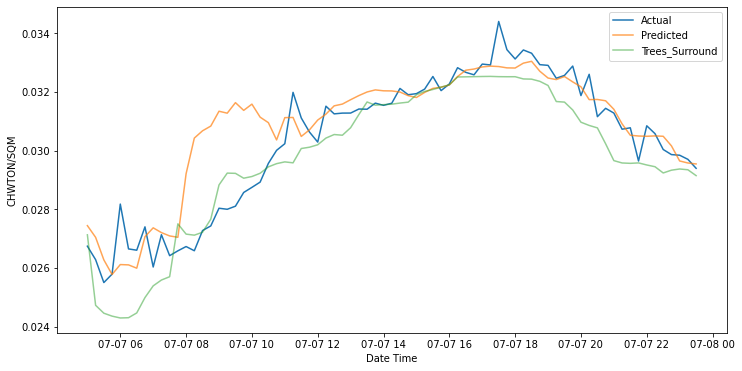

Wall_Shade
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.253503448555967
Percent Difference:  -2.3562908779519436


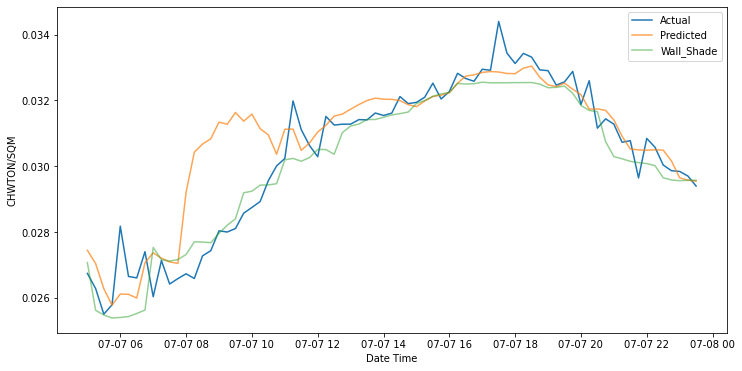

PV_Sidewalks
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.2572980864787096
Percent Difference:  -2.191870219182058


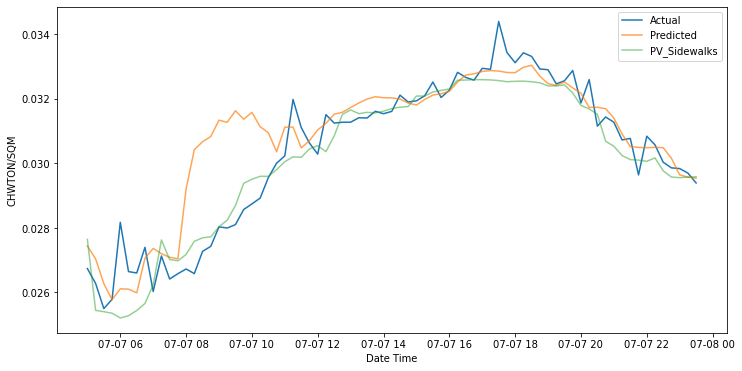

PV_Rooftop_and_Trees
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.2394436416113495
Percent Difference:  -2.965498598708745


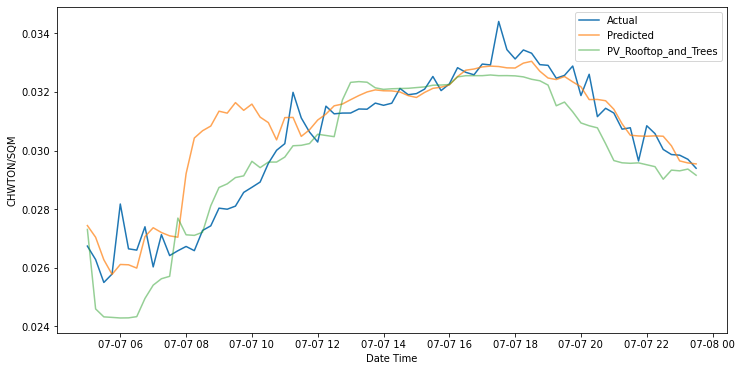

Trees_Extreme
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.1940248737564896
Percent Difference:  -4.933481811667038


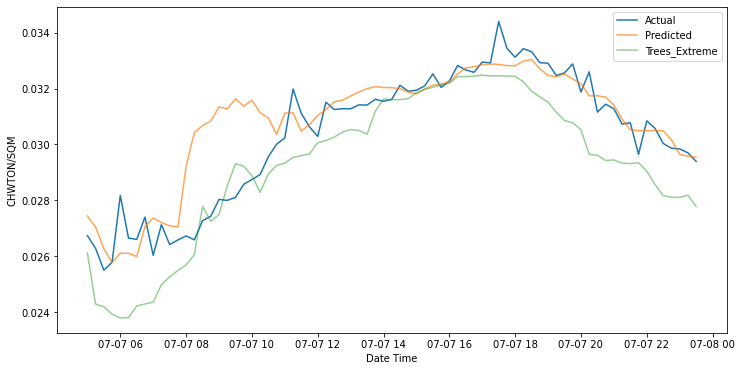

PV_Rooftop
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.2654795954236615
Percent Difference:  -1.8373675978915351


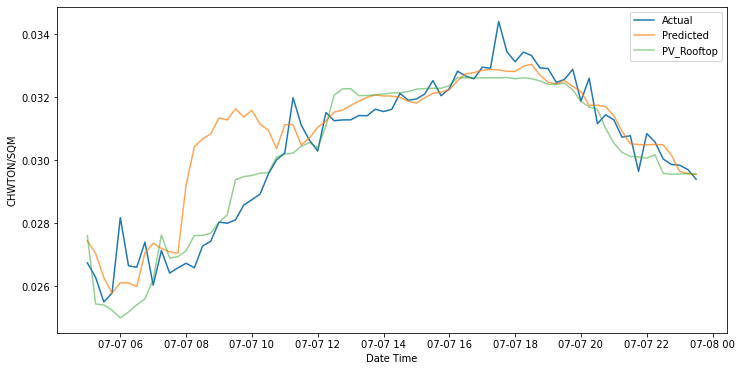

PV_Sidewalks_2
Prediceted Total (CHWTON/SWM):  2.307883906518995
Scenario Total (CHWTON/SWM):   2.257337967334849
Percent Difference:  -2.1901421922207964


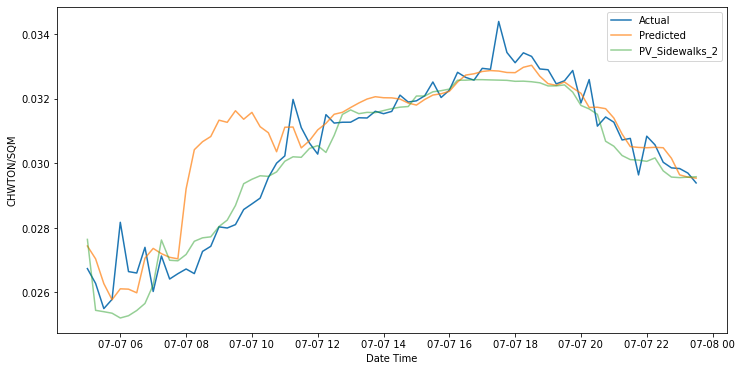

In [90]:
folder_path = '/Users/alialyakoob/Dropbox/ENVI-met/Model_2/Scenario_Dataset/'
scens = os.listdir(folder_path)
scens = list(filter(lambda x: x != '.DS_Store', scens))  


for i in scens:

    scen_data = pd.read_csv('/Users/alialyakoob/Dropbox/ENVI-met/Model_2/Scenario_Dataset/' + 
                            i + '/Psychology.csv')
    scen_data['Date_Time'] = pd.to_datetime(scen_data['Date_Time'])
    scen_data = scen_data[(scen_data['Date_Time'].dt.month == 7) & (scen_data['Date_Time'].dt.day == 7)]
    #scen_data = scen_data[(scen_data['Date_Time'].dt.hour >= 8) & (scen_data['Date_Time'].dt.hour <= 20)]
    scen_data = scen_data.drop_duplicates(subset=['Date_Time'])


    X_scen = scen_data[X_test.columns]
    scen_pred = best_rf_model.predict(X_scen)

    # Extract Date_Time for the test set
    date_time_test = df[(df['Date_Time'].dt.month == 7) & (df['Date_Time'].dt.day == 7)]['Date_Time']

    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        'Date_Time': date_time_test,
        'Actual': y_test,
        'Predicted': y_pred,
        'Scenario' : scen_pred
    })

    # Calculations
    sum_p = sum(plot_df['Predicted'])
    sum_s = sum(plot_df['Scenario'])
    print("\033[1m" + i + "\033[0m")
    print('Prediceted Total (CHWTON/SWM): ', sum_p)
    print('Scenario Total (CHWTON/SWM):  ', sum_s)
    print('Percent Difference: ', ((sum_s - sum_p)/sum_p)*100)
    
    # Sort by Date_Time
    plot_df.sort_values(by='Date_Time', inplace=True)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df['Date_Time'], plot_df['Actual'], label='Actual')
    plt.plot(plot_df['Date_Time'], plot_df['Predicted'], label='Predicted', alpha=0.7)
    plt.plot(plot_df['Date_Time'], plot_df['Scenario'], label= i, alpha = 0.5)
    plt.xlabel('Date Time')
    plt.ylabel('CHWTON/SQM')
    plt.legend()
    plt.show()



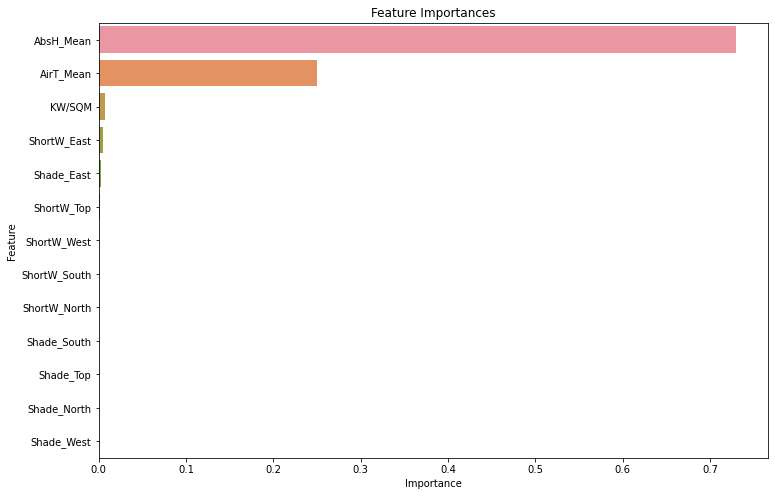

In [91]:
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
# Combine importances and feature names into a DataFrame and sort
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


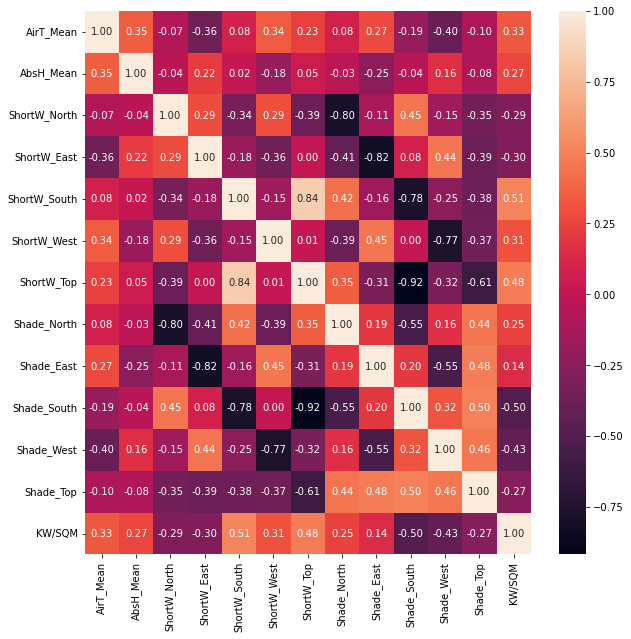

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()
